# Implementing Support Vector Machines with graph kernel

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy import optimize
import networkx as nx
from hashlib import blake2b
from collections import Counter, defaultdict
import itertools
from tqdm import tqdm
import time
import pandas as pd
import grakel

In [2]:
#train_path = "./data-challenge-kernel-methods-2022-2023/training_data.pkl"
#train_labels_path = "./data-challenge-kernel-methods-2022-2023/training_labels.pkl"
#test_path = "./data-challenge-kernel-methods-2022-2023/test_data.pkl"

train_path = "../data/training_data.pkl"
train_labels_path = "../data/training_labels.pkl"
test_path = "../data/test_data.pkl"

In [3]:
with open(train_path, "rb") as f:
    train_data = pickle.load(f)

with open(train_labels_path, "rb") as f:
    train_labels = pickle.load(f)

f.close()

In [4]:
train_data = np.array(train_data, dtype=object)
train_labels = np.array(train_labels, dtype=object)

In [5]:
train_labels_svm = train_labels.copy()
train_labels_svm[train_labels_svm == 0] = -1
np.unique(train_labels_svm)

array([-1, 1], dtype=object)

In [6]:
class KernelSVC:
    
    def __init__(self, C, kernel_mat, epsilon = 1e-3):
        self.type = 'non-linear'
        self.C = C                               
        self.kernel = kernel_mat        
        self.alpha = None
        self.support = None
        self.epsilon = epsilon
        self.norm_f = None
       
    
    def fit(self, X, y):
       #### You might define here any variable needed for the rest of the code
        N = len(y)
        K = self.kernel(X, X)
        
        # Store training data
        self.X_train = X
        self.obs_train = y

        # define matrix form of inequality constraints on dual problem
        ineq_A = np.vstack([np.eye(N), -np.eye(N)])
        ineq_b = np.array([self.C]*N + [0]*N)

        # Lagrange dual problem
        def loss(alpha):
            # The dual problem is a max pb => max f = min -f
            return .5*(alpha*y).T@K@(alpha*y) - alpha.sum()

        # Partial derivate of Ld on alpha
        def grad_loss(alpha):
            return y*((alpha*y)@K) - 1


        # Constraints on alpha of the shape :
        # -  d - C*alpha  = 0
        # -  b - A*alpha >= 0

        fun_eq = lambda alpha: alpha@y
        jac_eq = lambda alpha: y
        fun_ineq = lambda alpha: ineq_b - ineq_A@alpha
        jac_ineq = lambda alpha: -ineq_A
        
        constraints = ({'type': 'eq',  'fun': fun_eq, 'jac': jac_eq},
                       {'type': 'ineq', 
                        'fun': fun_ineq , 
                        'jac': jac_ineq})
        
        time_start = time.time()

        optRes = optimize.minimize(fun=lambda alpha: loss(alpha),
                                   x0=np.ones(N), 
                                   method='SLSQP', 
                                   jac=lambda alpha: grad_loss(alpha), 
                                   constraints=constraints,
                                   options={"maxiter": 10})
        
        print(f"Time for optimization: {time.time() - time_start}")
        self.alpha = optRes.x

        ## Assign the required attributes
        margin_idx = (self.alpha >= self.epsilon)
        sv_idx = (self.alpha >= self.epsilon) * (self.C - self.alpha >= self.epsilon)
        self.support = X[sv_idx]
        self.margin_points = X[margin_idx]
        self.margin_obs = y[margin_idx]
        self.margin_alpha = self.alpha[margin_idx]
        self.support_obs = y[sv_idx]
        self.support_alpha = self.alpha[sv_idx]
        
        # Take mean of offsets for more robust approximation
        self.b = np.mean(y[sv_idx] - self.separating_function(self.support))
        self.norm_f = np.sqrt(self.margin_alpha@self.kernel(self.margin_points, self.margin_points)@self.margin_alpha)


    ### Implementation of the separting function $f$ 
    def separating_function(self,x):
        # Input : matrix x of shape N data points times d dimension
        # Output: vector of size N
        
        return (self.support_alpha*self.support_obs).T@self.kernel(self.support, x)
    
    
    def predict(self, X):
        """ Predict y values in {-1, 1} """
        d = self.separating_function(X)
        return 2*(d+self.b > 0) - 1

In [7]:
class RandomWalkKernel:
    def __init__(self, l_walk, n_walks):
        self.l = l_walk
        self.n_walks = n_walks
    
    def perform_random_walk(self, edge_list, g, rdm_node):
        curr_node = rdm_node
        s = ''
        for _ in range(self.l + 1):
            s += str(g.nodes[curr_node]['labels'][0])
            # Undirected graph !
            sample_neighbor = edge_list.loc[(edge_list['source'] == curr_node) + (edge_list["target"] == curr_node), :]
            if len(sample_neighbor) == 0:
                continue
            else:
                sample_neighbor = sample_neighbor.sample()
            # Get new node
            if sample_neighbor["source"].values == curr_node:
                next_node = sample_neighbor["target"].values[0]
            else:
                next_node = sample_neighbor["source"].values[0]

            s+= str(sample_neighbor["labels"].values[0][0])
            curr_node = next_node  
        return s
        
    def compute_kernel(self, g0, g1):
        
        # Store edge list
        edges_g0 = nx.to_pandas_edgelist(g0)
        edges_g1 = nx.to_pandas_edgelist(g1)

        # Run random walks
        seq_g0 = []
        seq_g1 = []
        for _ in range(self.n_walks):
            rdm_node_g0 = np.random.choice(g0.nodes)
            seq_g0.append(self.perform_random_walk(edges_g0, g0, rdm_node_g0))

            rdm_node_g1 = np.random.choice(g1.nodes)
            seq_g1.append(self.perform_random_walk(edges_g1, g1, rdm_node_g1))

        # Compute kernel
        keys, vals = np.unique(seq_g1, return_counts=True)
        dico_g1 = dict(zip(list(keys), list(vals)))

        keys, vals = np.unique(seq_g0, return_counts=True)
        dico_g0 = dict(zip(list(keys), list(vals)))
        common_occ = 0
        for good_seq in np.intersect1d(seq_g0, seq_g1):
            common_occ += min(int(dico_g0[good_seq]), int(dico_g1[good_seq]))
        
        common_occ /= self.n_walks
        
        return common_occ
    
    def compute_kernel_matrix(self, X, Y):
        k = np.zeros((len(X), len(Y)))
        for i in range(len(X)):
            for j in range(i, len(Y)):
                k[i, j] = self.compute_kernel(X[i], Y[j]) 
                k[j, i] = k[i,j]
        return k

In [8]:
class WLKernel:
    def __init__(self, edge_attr="labels", node_attr="labels", iterations=3):
        self.edge_attr = edge_attr
        self.node_attr = node_attr
        self.n_iter = iterations
    
    def _hash_label(self, label, digest_size):
        return blake2b(label.encode("ascii"), digest_size=digest_size).hexdigest()

    def _neighborhood_aggregate(self, G, node, node_labels):
        """
        Compute new labels for given node by aggregating
        the labels of each node's neighbors.
        """
        label_list = []
        for nbr in G.neighbors(node):
            prefix = "" if self.edge_attr is None else str(G[node][nbr][self.edge_attr])
            label_list.append(prefix + node_labels[nbr])
        return node_labels[node] + "".join(sorted(label_list))

    def weisfeiler_lehman_graph_hash(self, G, digest_size=16):
        def weisfeiler_lehman_step(G, labels):
            """
            Apply neighborhood aggregation to each node
            in the graph.
            Computes a dictionary with labels for each node.
            """
            new_labels = {}
            for node in G.nodes():
                label = self._neighborhood_aggregate(G, node, labels)
                new_labels[node] = self._hash_label(label, digest_size)
            return new_labels

        # set initial node labels
        node_labels = {u: str(dd[self.node_attr]) for u, dd in G.nodes(data=True)}

        subgraph_hash_counts = {}
        for it in range(self.n_iter):
            node_labels = weisfeiler_lehman_step(G, node_labels)
            counter = Counter(node_labels.values())
            # normalize counter
            total = np.sum(list(counter.values()))
            for k in counter:
                counter[k] /= total

            # sort the counter, extend total counts
            subgraph_hash_counts[it] = sorted(counter.items(), key=lambda x: x[0])

        # return _hash_label(str(tuple(subgraph_hash_counts)), digest_size)
        return subgraph_hash_counts
    
    
    def compute_phi(self, Z):
        phi_list = []
        for g in Z:
            phi_list.append(self.weisfeiler_lehman_graph_hash(g))
        return phi_list
    
    def compute_kernel(self, wl1, wl2):
        k = 0
        for i in range(self.n_iter):
            dict1 = dict(wl1[i])
            dict2 = dict(wl2[i])
            # take scalar product only on common keys
            common_keys = set(dict1.keys()).intersection(set(dict2.keys()))
            k += np.sum([dict1[c]*dict2[c] for c in common_keys])
        return k

    def compute_kernel_matrix(self, X, Y):
        # Precompute phi to deal only with dot products
        phi_X = self.compute_phi(X)
        if np.array_equal(X, Y):
            print("Not computing phi again as X=Y")
            phi_Y = phi_X.copy()
        else:
            phi_Y = self.compute_phi(Y)
        ker = np.zeros((len(X), len(Y)))
        count_iter = 0
        if len(X) == len(Y):
            for i in range(len(X)):
                for j in range(i, len(Y)):
                    ker[i, j] = self.compute_kernel(phi_X[i], phi_Y[j])
                    ker[j, i] = ker[i,j]
                count_iter += 1
                if count_iter % 100 == 0:
                    print(f"Iteration {count_iter}")
        else:
            for (i,j) in itertools.product(range(len(X)), range(len(Y))):
                ker[i,j] = self.compute_kernel(phi_X[i], phi_Y[j])
        print("Kernel computed")
        return ker

In [ ]:
class WLOptimalAssignment:
    '''
    The weisfeiler lehman optimal assigment kernel that works directly
    with networkx graphs.
    '''
    
    def __init__(self,
                 edge_attr="labels",
                 node_attr="labels",
                 n_iter=5):
        self.n_iter = n_iter
        
    def prepare_input(self,
                      G):
        '''
        Parameters
        -----------
            G: a list of networkx graphs
        
        Returns
        -----------
            H: a numpy array with the graph histograms
        '''
        
        

In [9]:
from sklearn.svm import SVC

In [10]:
from grakel.kernels import WeisfeilerLehmanOptimalAssignment

In [42]:
G_train = list(grakel.graph_from_networkx(train_data,
         node_labels_tag='labels',
         edge_labels_tag='labels'))

G_test = list(grakel.graph_from_networkx(test_data,
         node_labels_tag='labels',
         edge_labels_tag='labels'))

def reformat_graph(g):
    new_g = [g[0]]
    new_g.append({key: val[0] for key, val in g[1].items()})
    new_g.append({key: val[0] for key, val in g[2].items()})
    return new_g

G_train = [reformat_graph(g) for g in G_train]
G_test = [reformat_graph(g) for g in G_test]

wl_oa_kernel = WeisfeilerLehmanOptimalAssignment(n_iter=5)

K_train = wl_oa_kernel.fit_transform(G_train)
K_test = wl_oa_kernel.transform(G_test)

#save kernel matrices
np.save("../data/K_train_WL_OA_grakel.npy", K_train)
np.save("../data/K_test_WL_OA_grakel.npy", K_test)

In [18]:
wl_oa_kernel = WeisfeilerLehmanOptimalAssignment(n_iter=5)

In [19]:
K_train = wl_oa_kernel.fit_transform(G)

In [20]:
K_train.shape

(5000, 5000)

In [24]:
K_val = wl_oa_kernel.transform(G_train[5000:])

In [46]:
## logistic regression
from sklearn.linear_model import LogisticRegression

In [85]:
clf_log = LogisticRegression(penalty='elasticnet',
                             solver='saga',
                             l1_ratio=0.6,
                             class_weight="balanced")

In [86]:
clf_log.fit(K_train, train_labels_svm.astype(int))

/home/sebastian/anaconda3/envs/mva/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(class_weight='balanced', l1_ratio=0.6, penalty='elasticnet',
                   solver='saga')

In [87]:
y_pred = clf_log.predict(K_test)

In [88]:
y_pred.shape

(2000,)

(array([1226.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         774.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

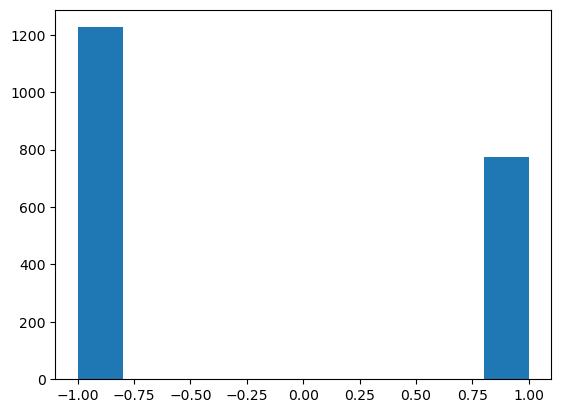

In [89]:
plt.hist(y_pred)

(array([1868.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         132.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

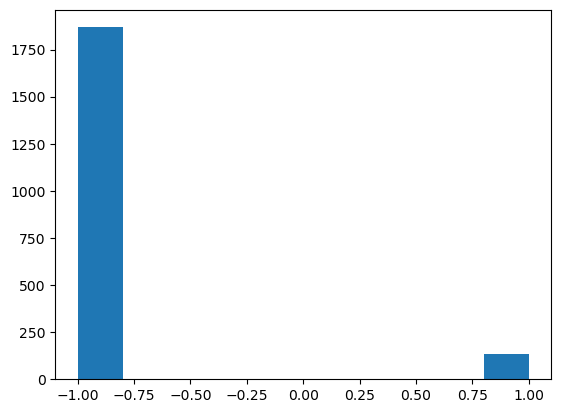

In [66]:
plt.hist(y_pred)

In [36]:
from sklearn.metrics import classification_report
print(classification_report(train_labels_svm[5000:].astype(int), y_pred))

              precision    recall  f1-score   support

          -1       0.98      0.99      0.99       971
           1       0.50      0.21      0.29        29

    accuracy                           0.97      1000
   macro avg       0.74      0.60      0.64      1000
weighted avg       0.96      0.97      0.97      1000



In [37]:
C = 1.
model = SVC(kernel='precomputed', C=C)
#model = KernelSVC(C=C, kernel_mat=kernel)
model.fit(K_train, train_labels_svm[:5000].astype(int))

y_pred2 = model.predict(K_val)

In [38]:
print(classification_report(train_labels_svm[5000:].astype(int), y_pred2))

              precision    recall  f1-score   support

          -1       0.98      0.98      0.98       971
           1       0.39      0.38      0.39        29

    accuracy                           0.96      1000
   macro avg       0.69      0.68      0.68      1000
weighted avg       0.96      0.96      0.96      1000



In [41]:
5500/6000

0.9166666666666666

(array([5445.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         555.]),
 array([-1.0, -0.8, -0.6, -0.3999999999999999, -0.19999999999999996, 0.0,
        0.20000000000000018, 0.40000000000000013, 0.6000000000000001, 0.8,
        1.0], dtype=object),
 <BarContainer object of 10 artists>)

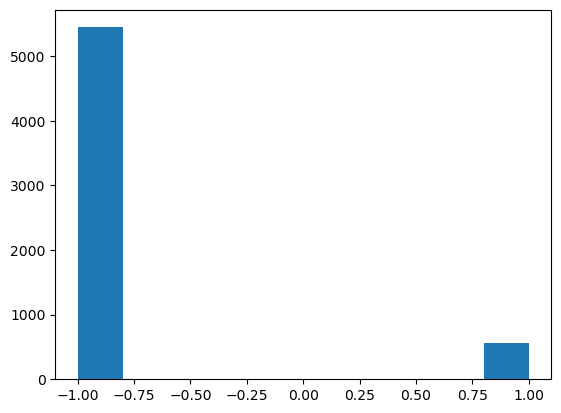

In [40]:
plt.hist(train_labels_svm)

In [32]:
y_pred

array([-1, 1], dtype=object)

In [47]:
C = 100
kernel = WLKernel(iterations=10).compute_kernel_matrix

In [48]:
K = kernel(train_data, train_data)

Not computing phi again as X=Y
Iteration 100
Iteration 200
Iteration 300
Iteration 400
Iteration 500
Iteration 600
Iteration 700
Iteration 800
Iteration 900
Iteration 1000
Iteration 1100
Iteration 1200
Iteration 1300
Iteration 1400
Iteration 1500
Iteration 1600
Iteration 1700
Iteration 1800
Iteration 1900
Iteration 2000
Iteration 2100
Iteration 2200
Iteration 2300
Iteration 2400
Iteration 2500
Iteration 2600
Iteration 2700
Iteration 2800
Iteration 2900
Iteration 3000
Iteration 3100
Iteration 3200
Iteration 3300
Iteration 3400
Iteration 3500
Iteration 3600
Iteration 3700
Iteration 3800
Iteration 3900
Iteration 4000
Iteration 4100
Iteration 4200
Iteration 4300
Iteration 4400
Iteration 4500
Iteration 4600
Iteration 4700
Iteration 4800
Iteration 4900
Iteration 5000
Iteration 5100
Iteration 5200
Iteration 5300
Iteration 5400
Iteration 5500
Iteration 5600
Iteration 5700
Iteration 5800
Iteration 5900
Iteration 6000
Kernel computed


In [49]:
np.save('../data/WL_kernel_train_10it.npy', K)

In [53]:
K_test = kernel(test_data, train_data)

Kernel computed


In [54]:
np.save('../data/WL_kernel_test_10it.npy', K_test)

In [27]:
K_test.shape

(2000, 6000)

In [50]:
C = 100.
model = SVC(kernel='precomputed', C=C)
#model = KernelSVC(C=C, kernel_mat=kernel)
model.fit(K, train_labels_svm)

SVC(C=100.0, kernel='precomputed')

In [42]:
K

array([[0.515625  , 0.14322917, 0.13888889, ..., 0.02083333, 0.28125   ,
        0.02678571],
       [0.14322917, 0.44791667, 0.11342593, ..., 0.        , 0.34895833,
        0.00595238],
       [0.13888889, 0.11342593, 0.45679012, ..., 0.        , 0.13888889,
        0.01587302],
       ...,
       [0.02083333, 0.        , 0.        , ..., 1.38888889, 0.09375   ,
        0.05952381],
       [0.28125   , 0.34895833, 0.13888889, ..., 0.09375   , 1.2109375 ,
        0.02232143],
       [0.02678571, 0.00595238, 0.01587302, ..., 0.05952381, 0.02232143,
        0.6122449 ]])

In [51]:
test = model.predict(K)

In [52]:
from sklearn.metrics import classification_report
print(classification_report(train_labels_svm, test))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      5445
           1       0.99      0.95      0.97       555

    accuracy                           0.99      6000
   macro avg       0.99      0.98      0.98      6000
weighted avg       0.99      0.99      0.99      6000



## Save to csv

In [22]:
with open(test_path, "rb") as f:
    test_data = pickle.load(f)
    
f.close()

test_data = np.array(test_data, dtype=object)

In [29]:
test_preds = model.predict(K_test)

In [31]:
test_preds

array([-1, -1, -1, ..., -1,  1, -1])

In [36]:
# original labels are in {0, 1}
test_preds[test_preds == -1] = 0
Yte = {'Predicted' : test_preds}
dataframe = pd.DataFrame(Yte) 
dataframe.index += 1 
dataframe.to_csv('../data/test_pred.csv',index_label='Id')

In [38]:
dataframe.to_csv('../data/test_pred.csv',index_label='Id')

In [52]:
df['Predicted'] = 0

In [57]:
df.to_csv('../data/test_pred_zeros.csv', index=False)

In [49]:
df = pd.read_csv('../data/test_pred.csv')

In [56]:
df

,Id,Predicted
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
1995,1996,0
1996,1997,0
1997,1998,0
1998,1999,0
